In [1]:
using CABLAB
include("Optimize_NPP.jl")
registerDATFunction(optimize_npp,(TimeAxis,VariableAxis));
registerDATFunction(predict_npp,((TimeAxis,VariableAxis),()),(TimeAxis,)); 

LoadError: LoadError: could not open file /Net/Groups/BGI/people/fgans/notebooktest/JuliaDATDemo/Optimize_NPP.jl
while loading In[1], in expression starting on line 2

**Comments: Need the file to execute the Notebook**

Here, we want to show how the cube and the DAT might be used for model parameter estimation. It also shows how the mapCube function can be applied on multiple input data cubes. 

In the file *Optimize_NPP.jl* we defined a function called **predict_npp** which predicts the ecosystem's net productivity (**NPP**) based on air temperature, fpar and radiation using a very simple model. One of the model parameters is the optimal growing temperature **Topt** at which the productivity reaches its maximum. We assume that this parameter varies across ecosystems, because they adapt to their normal environmental conditions. 

In [3]:
c             = Cube("/Net/Groups/BGI/scratch/fgans/cubecopy/datacube/")
vars          = ["t2m","fpar","Rg"];
cdata         = getCubeData(c,variable=vars,longitude=(-10,35),latitude=(35,65));

In [4]:
cdata_filled  = mapCube(gapFillMSC,cdata);

In the first experiment we assume that the model parameter **Topt** equals the mean temperature of each grid cell.

In [5]:
tair=getCubeData(c,variable="t2m",longitude=(-10,35),latitude=(35,65))
mtair=mapCube(timeMean,tair);

We pass the mean air temperature mtair as a second cube argument to the **mapCube** function.

In [6]:
predict_nppmean=mapCube(predict_npp,(cdata_filled,mtair));

Now, we can plot time series and maps of the predicted NEE. 

Interact.Slider{Float64}(Signal{Float64}(12.25, nactions=0),"Longitude",12.25,-10.0:0.25:34.75,true)

Interact.Slider{Float64}(Signal{Float64}(50.0, nactions=0),"Latitude",50.0,35.25:0.25:65.0,true)

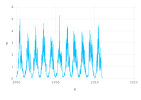

In [7]:
plotTS(predict_nppmean)

Interact.Slider{Int64}(Signal{Int64}(253, nactions=0),"Time Step",253,1:506,true)

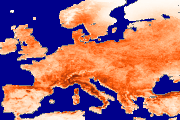

In [8]:
plotMAP(predict_nppmean)

Now we want to estimate the optimal growing temperature differently. Instead of just calculating the mean temperature we choose **Topt** so that the time mean of **NEE** is maximised for each gride cell. We do this by wrapping an optimization method from Julia's Optim package. 

In [9]:
topt=mapCube(optimize_npp,cdata_filled);

And we get a map of the optimal growing temperature

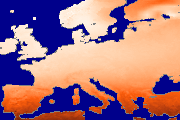

In [10]:
plotMAP(topt)

And the resulting NEE

In [11]:
predict_nppopt=mapCube(predict_npp,(cdata_filled,topt));

Interact.Slider{Int64}(Signal{Int64}(253, nactions=0),"Time Step",253,1:506,true)

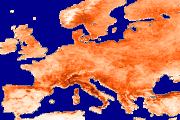

In [12]:
plotMAP(predict_nppopt)

In order to calculate the global map of Topt we add a few processors and repate the saem steps on the global cube

In [21]:
#using ClusterBGC
#addprocs_lsf(20,queue="BTM")
addprocs(10)
@everywhere include("Optimize_NPP.jl")

In [23]:
CABLAB.DAT.init_DATworkers()

In [24]:
cdata         = getCubeData(c,variable=vars);
@time cdata_filled  = mapCube(gapFillMSC,cdata);
@time topt=mapCube(optimize_npp,cdata_filled,max_cache=1e7);

130.612508 seconds (4.50 M allocations: 177.970 MB, 0.15% gc time)
 36.799817 seconds (1.59 M allocations: 95.447 MB, 0.12% gc time)


We can compare the optimum growing temperature (first plot) with the mean air temperature (second plot). In very cold regions you see that **Topt** is higher, probably because of the low temperatures occur when fpar and radiation are also very low and carbon uptake is not possible. 

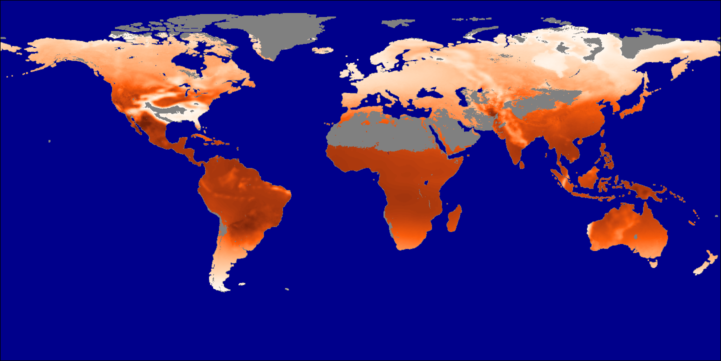

In [25]:
plotMAP(topt,dmin=0.f0,dmax=30.f0)

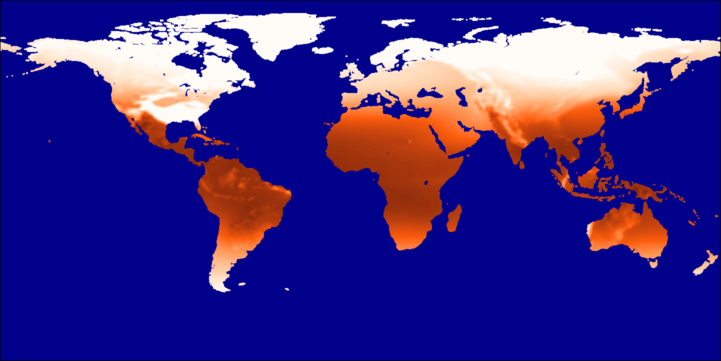

  5.829765 seconds (390.45 k allocations: 25.836 MB, 0.48% gc time)


In [26]:
tair=getCubeData(c,variable="t2m")
@time mtair=mapCube(timeMean,tair);
plotMAP(mtair,dmin=0.f0,dmax=30.f0)

In [17]:
rmprocs(workers())

:ok